# RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin)/num_points
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        # Create batch time serie on the x axis
        batch_ts = ts_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # FORMATTING for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

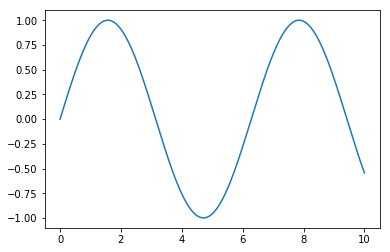

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

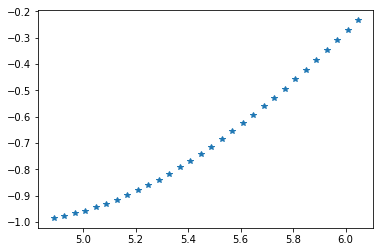

In [7]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

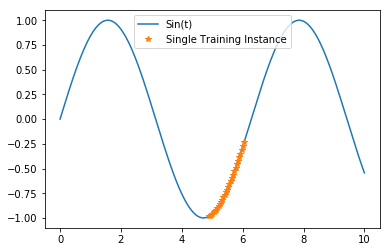

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label="Single Training Instance")

plt.legend()

In [9]:
# TRAINING DATA

In [10]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

In [11]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

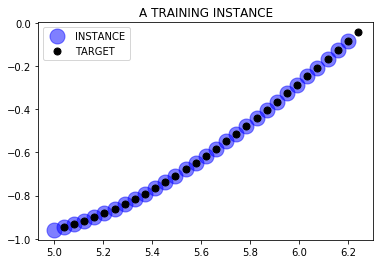

In [12]:
plt.title('A TRAINING INSTANCE')
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),'bo', markersize=15, alpha=0.5, label='INSTANCE')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),'ko', markersize=7, label='TARGET')
plt.legend()

## Creating the Model

In [13]:
tf.reset_default_graph()

In [14]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

In [15]:
# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [16]:
# RNN CELL LAYER
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu), 
                                              output_size=num_outputs)

In [17]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [18]:
# MSE
loss = tf.reduce_mean(tf.square(outputs-y))

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [20]:
train = optimizer.minimize(loss)

In [21]:
init = tf.global_variables_initializer()

In [22]:
# SESSION
saver = tf.train.Saver()

In [24]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict = {X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./rnn_time_series_model_codealong")

0 	MSE 0.425929
100 	MSE 0.0780777
200 	MSE 0.0457424
300 	MSE 0.0604514
400 	MSE 0.00383
500 	MSE 0.0141008
600 	MSE 0.0151955
700 	MSE 0.00262118
800 	MSE 0.00542649
900 	MSE 0.00516106
1000 	MSE 0.00197157
1100 	MSE 0.0134471
1200 	MSE 0.0119208
1300 	MSE 0.00268382
1400 	MSE 0.00746705
1500 	MSE 0.0111097
1600 	MSE 0.0117021
1700 	MSE 0.0014087
1800 	MSE 0.00811667
1900 	MSE 0.00337331


In [25]:
with tf.Session() as sess:
    
    saver.restore(sess, "./rnn_time_series_model_codealong")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


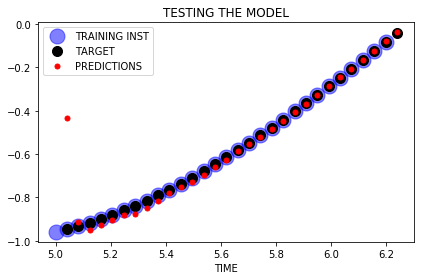

In [26]:
plt.title("TESTING THE MODEL")

# TRAINING INSTANCE
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="TRAINING INST")

# TARGET TO PREDICT (CORRECT TEST VALUES NP.SIZ(TRAIN))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="TARGET")

# MODULES PREDICTION
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label="PREDICTIONS")

plt.xlabel("TIME")
plt.legend()
plt.tight_layout()